# ハンズオン: TensorBoardを使ったモデルのチューニング
    - 質問などありましたら， 上野山 ( t.uenoyama@gmail.com, @araneko ) までお気軽に

### 必要なモジュールを読み込む

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils import resample

### MNISTデータの取得とプレビュー
- mnist.train.images: 訓練用イメージデータが配列で格納されている。1枚のイメージはベクトルになっていることに注意。
- mnist.train.labels: 訓練用のラベルデータ。1-of-K 表現。
- mnist.validation.images: バリデーション用イメージデータ。
- mnist.validation.labels: バリデーション用ラベルデータ。
- mnist.test.images: テスト用イメージデータ。
- mnist.test.labels: テスト用ラベルデータ。

In [2]:
# データのダウンロードと展開
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# データセットの枚数を確認
print('train: ', len(mnist.train.images))
print('valid: ', len(mnist.validation.images))
print('test: ', len(mnist.test.images))

train:  55000
valid:  5000
test:  10000


[7 3 4 6]


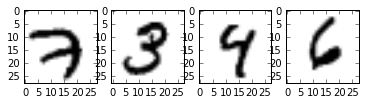

In [4]:
# 訓練画像の先頭４毎を描画
for i in range(0, 4):
    plt.subplot(141 + i)
    plt.imshow(-mnist.train.images[i].reshape(28, 28), cmap=plt.cm.gray)
print(np.argmax(mnist.train.labels[0:4,], axis=1))

## TensorFlow でMLP

別のシェルで TensorBoard を立ち上げておく。
```
mkdir -p data
rm -rf data/*
tensorboard --logdir=$PWD/data
```
その後，ブラウザで `http://127.0.0.1:6006/` を開く。

### 学習したいモデルを記述する

In [5]:
# 入力変数と出力変数のプレースホルダを生成
x = tf.placeholder(tf.float32, [None, 784], name='Image')
y_ = tf.placeholder(tf.float32, [None, 10], name='true_label')

# モデル式 (入力層:784ノード, 隠れ層:1000ノード, 隠れ層:1000ノード, 出力層:10ノード)
H1_NODE = 1000  # ★ 変えてみよう
H2_NODE = 1000  # ★ 変えてみよう

with tf.name_scope('fc_1'):
    W1 = tf.Variable(tf.truncated_normal([784, H1_NODE]), name='weight') 
    b1 = tf.Variable(tf.zeros([H1_NODE]), name='bias')
    h1 = tf.sigmoid(tf.matmul(x, W1) + b1) # 入力層->隠れ層

with tf.name_scope('fc_2'):
    W2 = tf.Variable(tf.truncated_normal([H1_NODE, H2_NODE]), name='weight')
    b2 = tf.Variable(tf.zeros([H2_NODE]), name='bias')
    h2 = tf.sigmoid(tf.matmul(h1, W2) + b2) # 隠れ層->隠れ層

with tf.name_scope('fc_3'):
    W3 = tf.Variable(tf.truncated_normal([H2_NODE, 10]), name='weight')
    b3 = tf.Variable(tf.zeros([10]), name='bias')
    u = tf.matmul(h2, W3) + b3    # 隠れ層->出力層 (ロジット)
    y = tf.nn.softmax(u)         # 隠れ層->出力層 (ソフトマックス後)

### 学習やテストに必要な関数を定義する

In [6]:
with tf.name_scope('train'):
    # 誤差関数(loss)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(u, y_), name='Xent')
    xent_summ = tf.scalar_summary('learning/XEnt', loss)
    # 最適化手段(最急降下法)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss, global_step=global_step)

with tf.name_scope('eval'):
    # 正答率
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='Accuracy')
    acc_summ = tf.scalar_summary('learning/Accuracy', acc)

### 実際に学習処理を実行する

In [7]:
# すべてのサマリーを統合
merged_summ = tf.merge_all_summaries()

# セッションを準備
sess = tf.Session()

# セッション作成後に SummaryWriter を呼ぶことで， グラフ構造が出力される。
SESSION_NAME = 'sgd0.1_N1000_1000x1000'  # ★★ 毎回名前を変えると良い
train_writer = tf.train.SummaryWriter('data/mnist_' + SESSION_NAME + '/train', graph=sess.graph, flush_secs=10)
valid_writer = tf.train.SummaryWriter('data/mnist_' + SESSION_NAME + '/valid', flush_secs=10)

# 変数を初期化
sess.run(tf.initialize_all_variables())

In [8]:
NUM_TRAIN_SAMPLES = 1000  # ★ 変えてみよう
BATCH_SIZE = 100

train_images_subset = mnist.train.images[:NUM_TRAIN_SAMPLES]
train_labels_subset = mnist.train.labels[:NUM_TRAIN_SAMPLES]

for i in range(2001):  # ★ 増やしてみよう
    # バッチ型確率的勾配降下法でパラメータ更新
    batch_xs, batch_ys = resample(train_images_subset, train_labels_subset, n_samples = BATCH_SIZE)
    _, train_xent, train_acc, train_merged_summ, step = sess.run(
        [train_step, loss, acc, merged_summ, global_step], feed_dict={x: batch_xs, y_: batch_ys})
    train_writer.add_summary(train_merged_summ, step)
    
    if i % 10 == 0:
        # 10回の更新ごとに予測性能を出力
        valid_xent, valid_acc, valid_merged_summ, step = sess.run([loss, acc, merged_summ, global_step], 
                                         feed_dict={x: mnist.validation.images[0:1000], y_: mnist.validation.labels[0:1000]})
        valid_writer.add_summary(valid_merged_summ, step)
        print ("step=%3d, Xent(train)=%.2f, Acc(train)=%.2f, Xent(valid)=%.2f, Acc(valid)=%.2f" % 
               (step, train_xent, train_acc, valid_xent, valid_acc))

step=  1, Xent(train)=4.89, Acc(train)=0.10, Xent(valid)=4.66, Acc(valid)=0.10
step= 11, Xent(train)=3.69, Acc(train)=0.09, Xent(valid)=3.28, Acc(valid)=0.10
step= 21, Xent(train)=2.88, Acc(train)=0.11, Xent(valid)=2.82, Acc(valid)=0.12
step= 31, Xent(train)=2.56, Acc(train)=0.14, Xent(valid)=2.60, Acc(valid)=0.14
step= 41, Xent(train)=2.31, Acc(train)=0.25, Xent(valid)=2.47, Acc(valid)=0.17
step= 51, Xent(train)=2.41, Acc(train)=0.19, Xent(valid)=2.34, Acc(valid)=0.20
step= 61, Xent(train)=2.02, Acc(train)=0.35, Xent(valid)=2.25, Acc(valid)=0.23
step= 71, Xent(train)=1.90, Acc(train)=0.33, Xent(valid)=2.15, Acc(valid)=0.26
step= 81, Xent(train)=1.88, Acc(train)=0.32, Xent(valid)=2.07, Acc(valid)=0.30
step= 91, Xent(train)=1.72, Acc(train)=0.37, Xent(valid)=2.01, Acc(valid)=0.31
step=101, Xent(train)=1.90, Acc(train)=0.41, Xent(valid)=1.95, Acc(valid)=0.34
step=111, Xent(train)=1.96, Acc(train)=0.33, Xent(valid)=1.90, Acc(valid)=0.35
step=121, Xent(train)=1.93, Acc(train)=0.36, Xent(va

In [9]:
# バッファ内のサマリーデータを出力する
train_writer.flush()
valid_writer.flush()

### 後片付け

In [16]:
# セッションを閉じる
sess.close()